# 텍스트 데이터를 입력받아, 여러가지 텍스트마이닝 기법에 적용하여 결과를 확인합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 불러오기

* 명사 추출이 되어있는 텍스트 파일을 읽어온다.

In [ ]:
# 저장할 파일명에 들어갈 이름.
query_keyword = input("Please type the name you want : ")

Please type the name you want : final_eng
Which languages? (e.g. kor, eng) : eng


#### txt 파일을 불러오는 함수. 

In [ ]:
import pandas as pd

if language == "kor":
    base_path = "/content/drive/MyDrive/Colab Notebooks/공개정보 텍스트 분석 자료(210609-0611)/한글 텍스트 분석/" # 절대경로
    save_path = "/content/drive/MyDrive/Colab Notebooks/공개정보 텍스트 분석 자료(210609-0611)/실습결과/한글/"
    data = pd.read_excel(base_path + "2021NKAnalysis.xlsx")["content"] # content column만 가져옵니다.
elif language == "eng":
    base_path = "/content/drive/MyDrive/Colab Notebooks/공개정보 텍스트 분석 자료(210609-0611)/영어  텍스트 분석/" # 절대경로
    save_path = "/content/drive/MyDrive/Colab Notebooks/공개정보 텍스트 분석 자료(210609-0611)/실습결과/영문/"
    data = pd.read_excel(base_path + "38North_DB.xlsx")['Content (Article Text)'] # content column만 가져옵니다.
data

0      New commercial satellite imagery indicates con...
1      New commercial satellite imagery indicates con...
2      Asphalt laying is complete on the Sinuiju-boun...
3      Recent reports indicate that South Korean inte...
4      Despite North Korea’s previously stated ambiti...
                             ...                        
319    Satellite photography of the Sohae Satellite L...
320    As of March 29, 2012, preparations seem to be ...
321    I have been looking at options for how North K...
322    Background In early June 2011, China and the D...
323    This article is a “38 North” exclusive in coop...
Name: Content (Article Text), Length: 324, dtype: object

## 2. 전처리 함수 정의

In [ ]:
# predefined의 경우 필요한 POS를 여기에 추가하시면 됩니다.
ENG_POS = ["NN", "NNP", "VB", "JJ"] # english
KOR_POS = ["NNP"] # Korean
#####

def text_cleaning(doc, lang):
    # 한국어를 제외한 글자를 제거하는 패턴.
    if lang == "kor":
        doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    #doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    elif lang == "eng":
        doc = doc.lower()
        doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add('"""“')
    SW.add('"""')
    SW.add('NA')
    SW.add("영어")
    SW.add("한국어")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer, language):
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    language - "kor"(한글) or "eng"(영어)
    
    """
    
    # 한글인 경우에는 형태소 분석 결과를 return.
    # 윈도우 사용자의 경우에는 mecab.morphs 함수 대신에 mecab_morphs로 바꾼다.
    if language == "kor":
        if tokenizer == "noun":
            return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]    
        
        elif tokenizer == "morph":
            return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]

        elif tokenizer == "predefined":
            temp = mecab.pos(doc)
            # predefined에 정의된 POS만 불러옵니다.
            tokens = [token[0] for token in temp if token[1] in KOR_POS]
            return [word for word in tokens if word not in SW and len(word) > 1]
        
        elif tokenizer == "word":
            return [word for word in doc.split() if word not in SW and len(word) > 1]
    
    # 영문인 경우 POS tagging을 한 뒤에 필요한 tag가 붙어있는 품사만 가져온다.
    elif language == "eng":
        if tokenizer == "noun": # 명사 태그에 해당하는 token 추출.
            temp = word_tokenize(doc)
            nouns = [token[0] for token in pos_tag(temp) 
                     if token[1] == "NN" or token[1] == "NNP" or token[1] == "NNS" or
                    token[1] == "NNPS" or token[1] == "PRP" or token[1] == "PRP$"]


        # 원하는 품사들만 가져오는 tokenizier.
        elif tokenizer == "predefined":
            temp = word_tokenize(doc)
            # predefined에 정의된 POS만 불러옵니다.
            tokens = [token[0] for token in pos_tag(temp) if token[1] in ENG_POS]

        # POS tagging을 그대로 전부 사용하는 경우.
        elif tokenizer == "pos":
            temp = word_tokenize(doc)
            tokens = [word for word in pos_tag(temp) if word not in stop_words]
        
        # 단어만 추출하는 경우.
        elif tokenizer == "word":
            temp = word_tokenize(doc)
            tokens = [word for word in temp if word not in stop_words]
        
        tokenized_corpus = tokens

        return tokenized_corpus

### 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [ ]:
if language == "kor":
    !pip install konlpy
    !curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

elif language == "eng":
    import nltk
    nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
# 둘 중에 하나만 사용합니다.
# Colab용
# 윈도우10 jupyter notebook용
#import MeCab; mecab = MeCab.Tagger()
import pickle
import os
import re
from pprint import pprint
from tqdm import tqdm_notebook
from nltk import bigrams

if language == "kor":
    from konlpy.tag import Mecab; mecab = Mecab()
    from konlpy.tag import Komoran; komoran = Komoran()
    from konlpy.tag import Okt; okt = Okt() # 한국어 형태소분석기. Okt -> 간단하게 사용할 수 있고, 속도가 빠름. 단, 품사별로 나뉘는게 noun, verb 같은 큰 단위로만 나눠짐.

    SW = define_stopwords(base_path + "stopwords-ko.txt")
    SW_NK = define_stopwords(base_path + "stopwords-ko-NK.txt")
    SW_Job = define_stopwords(base_path + "stopwords-ko-Job.txt")
    SW_PN = define_stopwords(base_path + "stopwords-ko-PN.txt")

elif language == "eng":
    import nltk # Natural Language ToolKit. 영문 형태소 분석, POS tagging, 단어/문장 tokenzing 등등..
    from nltk import pos_tag # pos tagging(Part-of-Speech tagging)
    from nltk import word_tokenize # bigram, 단어 tokenizing.

    SW = define_stopwords(base_path + "stop_words_english.txt")

if os.path.exists(save_path+'tokenized_set({}).pk'.format(dataname)):
    with open(save_path+'tokenized_set({}).pk'.format(dataname), "rb") as f:
        tokenized_set = pickle.load(f)
        
else:
    cleaned_data = [text_cleaning(doc, language) for doc in data]
    # text_tokenizing 함수에는 (데이터, 품사, 언어) 정보가 들어가야 한다.
    # 만약에 여러 개의 품사를 사용하려면, 품사에 "predefined" 를 넣으면 된다.
    tokenized_set = []
    for idx in tqdm_notebook(range(len(cleaned_data))):
        tokenized_set.append(text_tokenizing(cleaned_data[idx], "predefined", language))
#    tokenized_set = [text_tokenizing(doc, "noun", "eng") for doc in cleaned_data]
    print("Cleaned Corpus : ", cleaned_data[0])
    
    with open(save_path+'tokenized_set({}).pk'.format(dataname), "wb") as f:
        pickle.dump(tokenized_set, f)

    with open(save_path+"tokenized_text({}).txt".format(dataname), 'w') as f:
        for doc in tokenized_set:
            print(" ".join(doc), file=f)
        
print("\n\nTokenized Corpus : ", tokenized_set[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Cleaned Corpus :  new commercial satellite imagery indicates considerable progress has been made on the pyongyang general hospital since april and that a number of large construction projects are also underway in the city center presumably these projects as well as construction at the  mirim parade training ground  are targeted for completion in advance of the th anniversary of the workers party of korea wpk in october pyongyang general hospital one of the largest projects underway is the construction of a general hospital on the bank of the taedong river which has made rapid progress over the past month imagery from june  indicates that tower  the southern tower has reached its top floor which shows a flared architectural design several floors have been added to tower  the northern tower  since april  with only one or two floors remaining before it reaches its final height the center structure which will support the helipad as per north koreas design is nearing completion with only t

## 3. 빈도 분석하기.

In [ ]:
from collections import Counter

total_tokens = [token for doc in tokenized_set for token in doc]
print("Number of Total tokens : ", len(total_tokens))

# 각 token 별로 빈도를 계산해주는 Counter 객체.
token_counter = Counter(total_tokens)

wordInfo = dict()
print("\n--Token : Freq--")
for tags, counts in token_counter.most_common(50): # top 50개 출력.
    wordInfo[tags] = counts
    print ("%6s : %d" % (tags, counts))

Number of Total tokens :  122311

--Token : Freq--
figure : 2619
 north : 2378
 image : 2239
    be : 1944
  test : 1894
   new : 1600
construction : 1482
contact : 1448
launch : 1404
thirtyeightnorthgmailcom : 1379
  area : 1317
imagery : 1308
activity : 1184
satellite : 982
distribution : 919
building : 902
please : 868
facility : 858
    ds : 838
nuclear : 838
portal : 796
  site : 792
reactor : 739
   pad : 723
support : 682
missile : 601
digitalglobe : 561
tunnel : 529
 korea : 523
 south : 518
engine : 499
rocket : 492
  have : 488
 stand : 485
 water : 479
 power : 469
commercial : 463
material : 463
present : 462
recent : 448
  work : 430
station : 419
  main : 414
korean : 411
 march : 411
 other : 410
  road : 409
 large : 407
 april : 395
 small : 390


### Histogram 그리기.

In [ ]:
# 그래프를 이쁘게 그리기 위한 코드입니다. 한글 글꼴을 추가합니다.

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져옵니다.
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

sys_font number: 48
['/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share

In [ ]:
# 여전히 글꼴이 보이지 않는 분들은, 런타임 -> "다시 시작 및 모두 실행" 을 눌러주세요!
fm._rebuild()

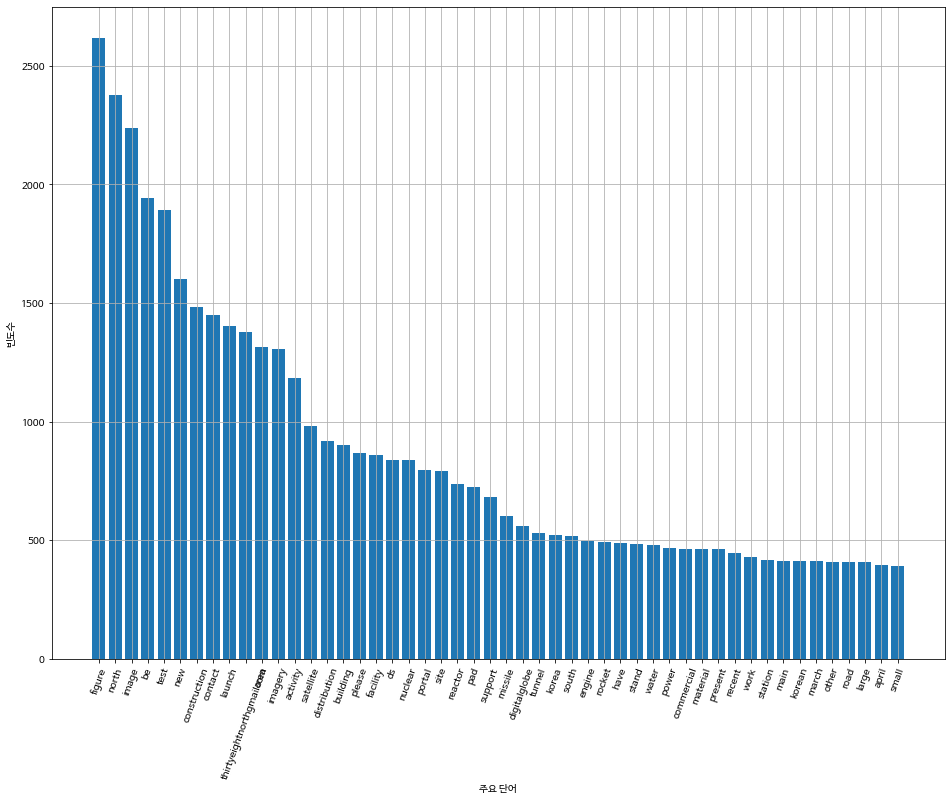

In [ ]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

plt.figure(figsize=(16, 12))
plt.xlabel('주요 단어')
plt.ylabel('빈도수')
plt.grid(True)

Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True)
Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True)

plt.bar(range(len(wordInfo)), Sorted_Dict_Values, align='center')
plt.xticks(range(len(wordInfo)), list(Sorted_Dict_Keys), rotation='70')
plt.savefig(save_path+"freq_dist.png")
plt.show()

### WordCloud 그리기.

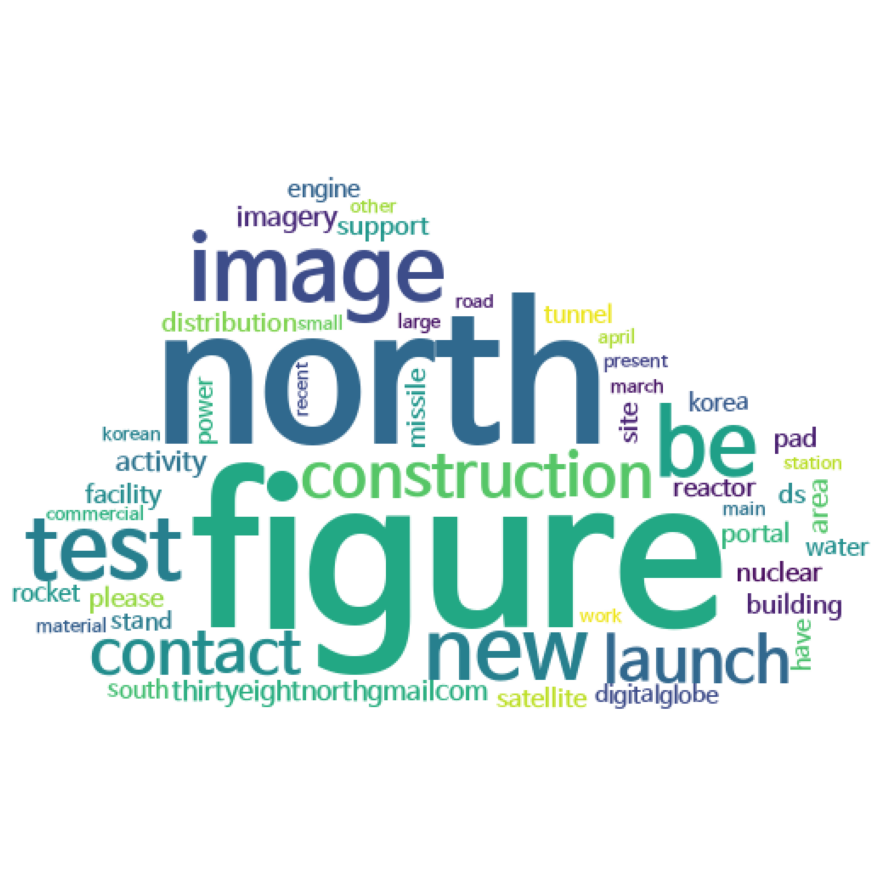

In [ ]:
from wordcloud import WordCloud

#data = text.vocab().most_common(100)
from PIL import Image
import numpy as np

mask = np.array(Image.open(base_path + "cloud.png"))

wordcloud = WordCloud(font_path=path,
                      relative_scaling = 0.2,
                      mask=mask,
                      background_color='white',
                      ).generate_from_frequencies(wordInfo)
plt.figure(figsize=(16,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(save_path+"wordcloud.png")
plt.show()

## 4. TF-IDF를 통한 주요 단어 분석하기.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#TfidfVectorizer의 input으로 만들기 위한 전처리.
tfidf_docs = [" ".join(doc) for doc in tokenized_set]

tfidf = TfidfVectorizer()

# tfidf 형태로 변환.
X_tfidf = tfidf.fit_transform(tfidf_docs)

terms = tfidf.get_feature_names()

# sum tfidf frequency of each term through documents
sums = X_tfidf.sum(axis=0)

# connecting term to its sums frequency
df = []
for col, term in enumerate(terms):
    df.append( (term, sums[0,col] ))

ranking = pd.DataFrame(df, columns=['Term','TF-IDF'])
rankInfo = ranking.sort_values('TF-IDF', ascending=False)[:50]
print(rankInfo)

                          Term     TF-IDF
6099                      test  30.032164
3340                    launch  26.273804
2846                     image  24.928978
4475                    portal  24.312273
2096                    figure  23.723965
4008                     north  21.958334
436                         be  18.560969
267                       area  18.482632
1108                   contact  18.363971
1100              construction  17.980987
56                    activity  17.632220
6152  thirtyeightnorthgmailcom  17.501582
3960                       new  16.948443
4822                   reactor  16.705706
4041                   nuclear  15.190674
4235                       pad  15.182667
1666                        ds  14.682982
1558              distribution  14.622975
4421                    please  14.397686
2850                   imagery  13.603964
1799                    engine  13.572302
6353                    tunnel  12.592675
591                   building  12

### TF-IDF Histogram 

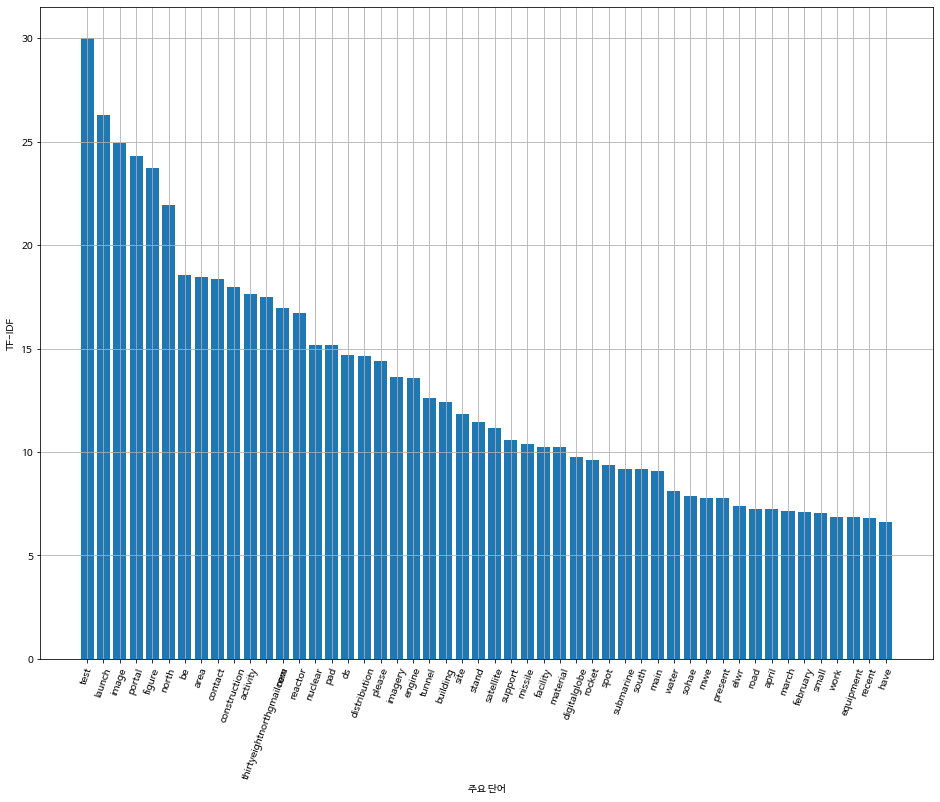

In [ ]:
tfidfInfo = dict()

for idx in range(len(rankInfo)):
    term = rankInfo.iloc[idx]["Term"]
    tfidf = rankInfo.iloc[idx]["TF-IDF"]
    tfidfInfo[term] = tfidf

plt.figure(figsize=(16, 12))
plt.xlabel('주요 단어')
plt.ylabel('TF-IDF')
plt.grid(True)

Sorted_Dict_Values = sorted(tfidfInfo.values(), reverse=True)
Sorted_Dict_Keys = sorted(tfidfInfo, key=tfidfInfo.get, reverse=True)

plt.bar(range(len(tfidfInfo)), Sorted_Dict_Values, align='center')
plt.xticks(range(len(tfidfInfo)), list(Sorted_Dict_Keys), rotation='70')
plt.savefig(save_path+"tfidf_dist.png")
plt.show()

### WordCloud 

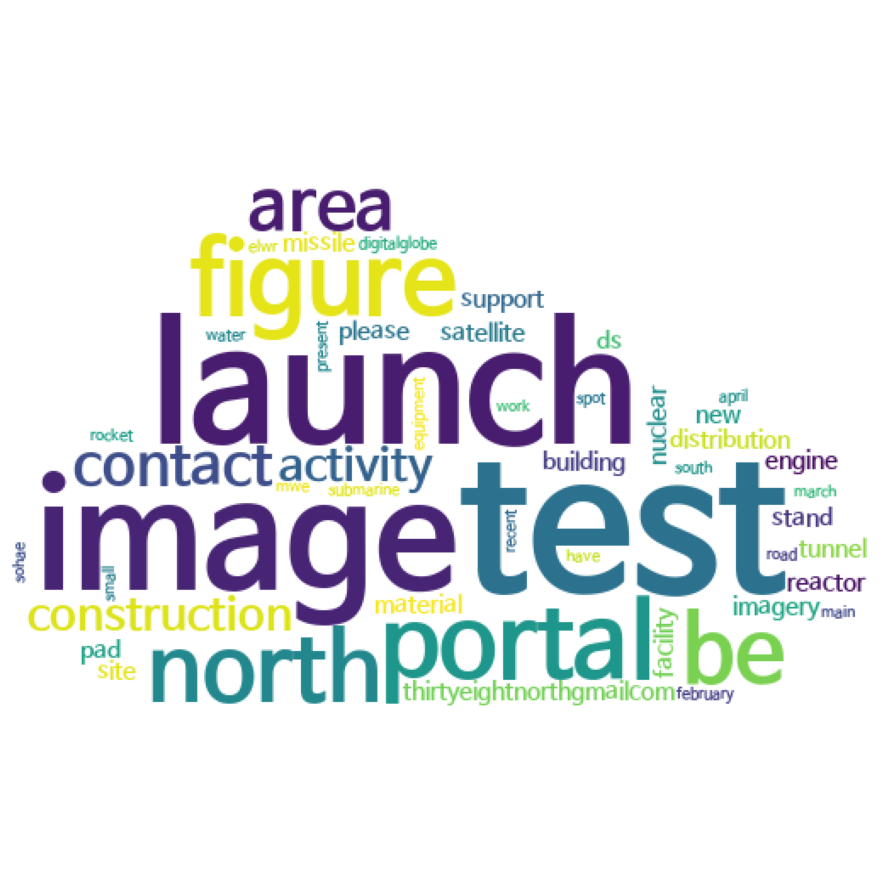

In [ ]:
from wordcloud import WordCloud

mask = np.array(Image.open(base_path + "cloud.png"))
wordcloud = WordCloud(font_path=path,
                      relative_scaling = 0.2,
                      mask=mask,
                      background_color='white',
                      ).generate_from_frequencies(tfidfInfo)
plt.figure(figsize=(16,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(save_path+"wordcloud.png")
plt.show()

In [ ]:
!pip install squarify

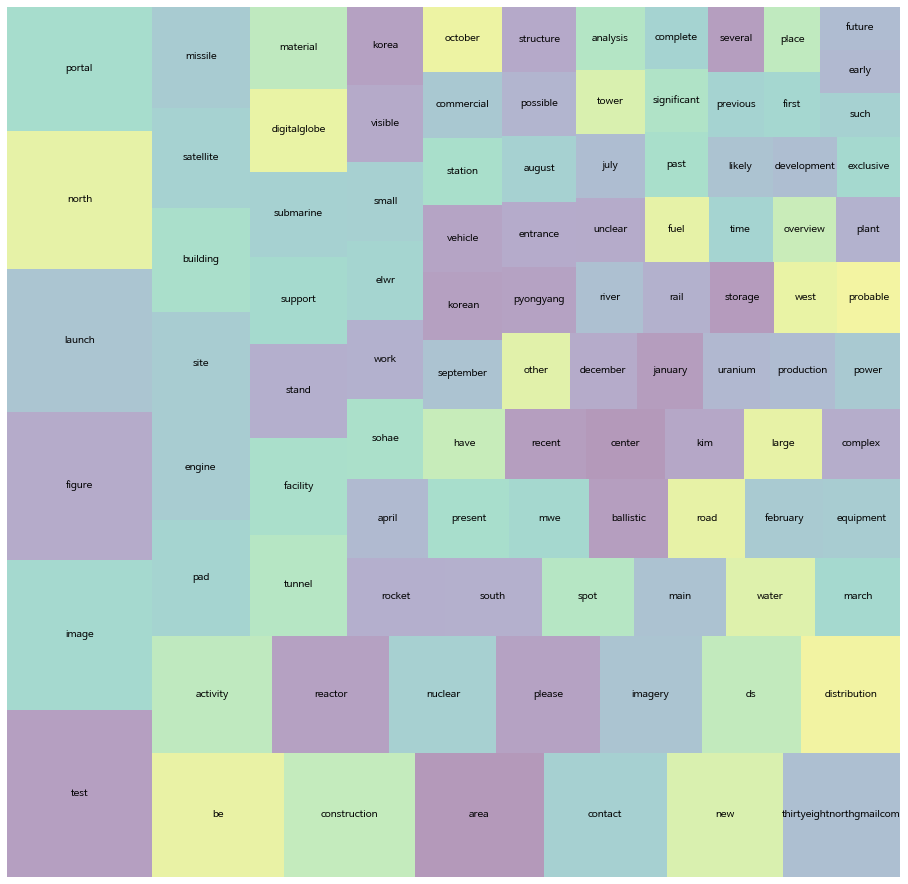

In [ ]:
import squarify

vectorizer = TfidfVectorizer(max_features=100)
count = vectorizer.fit_transform(tfidf_docs).toarray().sum(axis=0)

# 단어의 빈도 값이 큰 순으로 데이터의 index를 반환
idx = np.argsort(-count)
count = count[idx]

# 단어의 빈도 값이 큰 순으로 데이터의 index를 반환
feature_name = np.array(vectorizer.get_feature_names())[idx]

plt.figure(figsize=(16, 16))

def draw_treemap(feature_name, count):
    
    squarify.plot(sizes=count, label=feature_name, alpha=0.4)
    
    plt.axis("off")
    
    # 현재 폴더에 tdf_treemap.png 파일명으로 저장, dpi는 그림 해상도 지정 
    # bbox_inches='tight'는 그림을 둘러싼 여백 제거 
    plt.savefig(save_path+'tdf_treemap.png', dpi= 400, bbox_inches='tight');
    plt.show() 
    
draw_treemap(feature_name, count)

## 5. Topic Modeling을 위한 parameter setting 및 데이터 전처리.

In [ ]:
!pip install pyldavis==3.2.2

In [ ]:
start, end, step = [int(x) for x in input("토픽 개수를 입력하세요.(e.g. 2,10,1) : ").split(",")]

토픽 개수를 입력하세요.(e.g. 2,10,1) : 2,4,1


In [ ]:
import sys
from operator import itemgetter
from itertools import combinations
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from tqdm import tqdm_notebook
from konlpy.tag import Mecab #Komoran #Mecab #Okt
import numpy as np
import string
import re
import warnings
import networkx as nx
from gensim import corpora
from gensim import models
from gensim.models import TfidfModel
import pyLDAvis
import pyLDAvis.gensim


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

warnings.simplefilter(action='ignore')

#tfidf로 토픽 모델링을 하는 경우에는 True.
tfidf_mode = True
# 각 토픽모델 결과마다 상위 몇개의 단어를 사용할지.
NUM_TOPIC_WORDS = 30
# semantic network할때, co-occurence count를 상위 몇개를 사용할지.
NUM_WORD_COOCS = 100

write_flag = True

# 토픽 개수 지정
# start 개수부터, end 개수까지 토픽 개수를 지정. 밑의 경우에는 K= 2, 3, 4, 5, 6, 7.
x = range(start, end, step)

def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    print_log_msg("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    temp_corpus = [dictionary.doc2bow(document) for document in documents]
    
    if tfidf_mode:
        tfidf = TfidfModel(temp_corpus)
        corpus = tfidf[temp_corpus]
        
    else:
        corpus = temp_corpus

    print_log_msg("Done.")
    
    return corpus, dictionary
    


def print_log_msg(msg):
    """로그 메시지를 출력한다."""    
    print(msg, flush=True)
        
        
corpus, dictionary = build_doc_term_mat(tokenized_set)

Building document-term matrix.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Done.


## 6. Topic Modeling을 Coherence Score로 평가하기.

In [ ]:
from gensim.models import CoherenceModel # topic coherence score 계산하는 함수.
from gensim.models.ldamodel import LdaModel # LDA

def compute_coherence(dictionary, corpus, texts, start=2, end=41, step=4):
    """
    Input Parameter:
    
    dictionary - gensim dictionary
    corpus - gensim corpus
    texts - 토크나이징된 실제 문서
    start, end, step - 실제 실험하는 토픽 개수. 아무것도 넣어주지 않으면 2부터 41까지 4씩 키워가며 자동으로 지정.
    """
    
    coherence_score_list = []
    model_list = []
    
    # 모든 지정된 토픽 개수에 대해서 실행.
    for num_topics in tqdm_notebook(range(start, end, step)):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                         passes=300, update_every=1,
                         per_word_topics=True, iterations=300,
                         random_state=42, alpha='auto') # passes를 높여주면 성능이 올라감. 보통 100~500 사이 지정.
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score_list.append(coherence_model.get_coherence())
        
    return model_list, coherence_score_list


def print_topic_words(model):
    """토픽별 토픽 단어들을 화면에 인쇄한다."""
    
    print_log_msg("Printing topic words.")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))

        print("\n")
        

model_path = save_path+"LDA_model_" + dataname + "_(" + str(min(x))+'-'+str(max(x)) +  ")topics.pk"
csScore_path = save_path+"coherence-Scores_" + dataname + "_(" + str(min(x))+'-'+str(max(x)) +  ")topics.pk"


if write_flag:
    model_list, coherence_scores = compute_coherence(dictionary=dictionary, corpus=corpus, 
                                                     texts=tokenized_set, start=start, end=end, step=step)

    with open(model_path, 'wb') as f:
        pickle.dump(model_list, f)
        
    with open(csScore_path, 'wb') as f:
        pickle.dump(coherence_scores, f)
    
    with open(csScore_path[:-2]+".txt", 'w') as f:
        for idx, cs in zip(range(start, end, step), coherence_scores):
            print("# of Topics : ", idx, file=f)
            print("Coherence Score with C_V : %.3f" % cs, file=f)
            
else:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            model_list = pickle.load(f)

    if os.path.exists(csScore_path):
        with open(csScore_path, 'rb') as f:
            coherence_scores = pickle.load(f)

### Coherence Score 계산 후 시각화. 

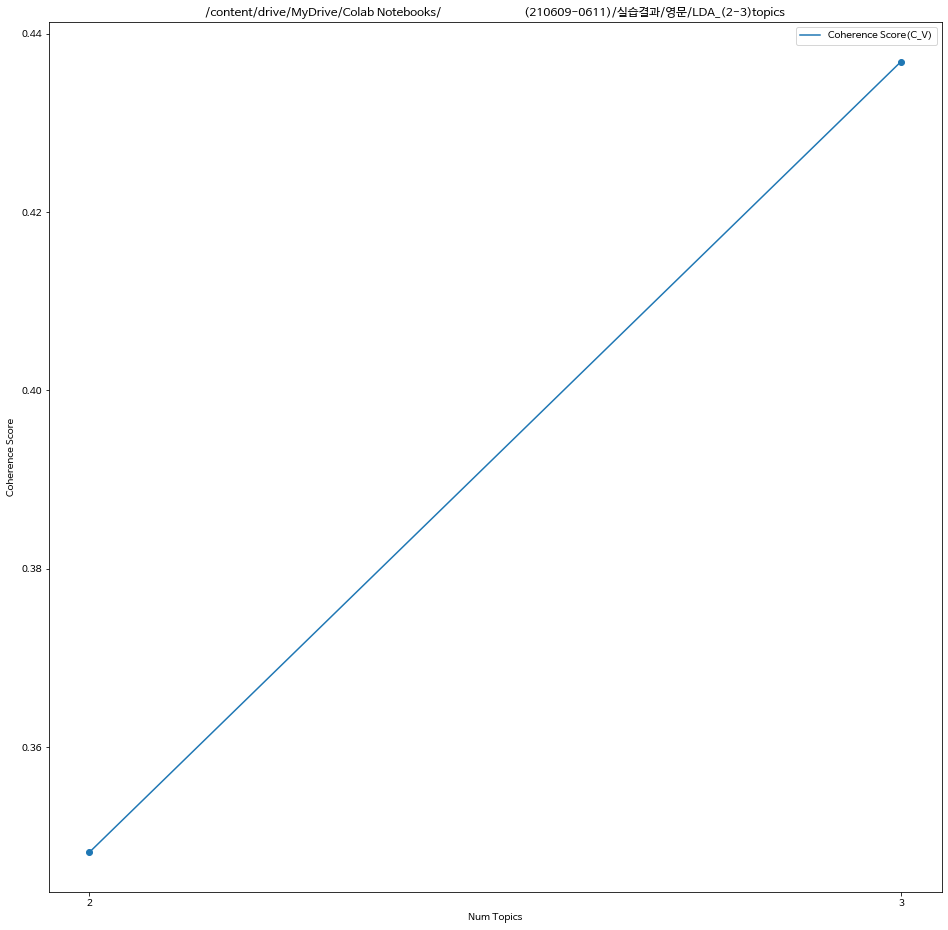

In [ ]:
plt.figure(figsize=(16, 16))
label = "Coherence Score(C_V)"
plt.plot(x, coherence_scores, label=label)
plt.scatter(x, coherence_scores)
plt.title(save_path+"LDA_({}-{})topics".format(str(min(x)), str(max(x))))
plt.xticks(x)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.savefig(save_path+"LDA_({}-{})topics.png".format(str(min(x)), str(max(x))))
plt.show()

In [ ]:
# Coherence Score(CS)가 가장 높은 Topic 개수를 자동으로 찾아서, LDA를 진행함.
coherence_list = np.array(coherence_scores)
model = model_list[np.argmax(coherence_list)]
NUM_TOPICS = model.num_topics # CS가 가장 높은 토픽 개수.
print("Number of Topics : ", NUM_TOPICS)
print_topic_words(model)

Number of Topics :  3
Printing topic words.
Topic ID: 0
	portal	0.0046624368987977505
	launch	0.0041220723651349545
	reactor	0.0031871821265667677
	test	0.0029624139424413443
	pad	0.002757646143436432
	engine	0.002573224250227213
	tunnel	0.002315451158210635
	nuclear	0.0020455466583371162
	stand	0.0020055437926203012
	ds	0.0019653753843158484
	submarine	0.0018912877421826124
	construction	0.001808781293220818
	rocket	0.0017552723875269294
	distribution	0.0017548316391184926
	spot	0.0017392071895301342
	missile	0.0016607610741630197
	mwe	0.0015696738846600056
	elwr	0.0015291068702936172
	sohae	0.0015091964742168784
	please	0.0015069333603605628
	material	0.001501143560744822
	area	0.0014467107830569148
	digitalglobe	0.0014093256322667003
	command	0.0013939572963863611
	building	0.0013937944313511252
	main	0.0013297453988343477
	water	0.0013188491575419903
	february	0.001300513045862317
	administrative	0.0012395702069625258
	spoil	0.0012195742456242442


Topic ID: 1
	abstract	0.000143533

In [ ]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.046911 -0.0       1        1  99.930358
2     -0.023455 -0.0       2        1   0.052111
1     -0.023455  0.0       3        1   0.017531, topic_info=               Term      Freq     Total Category  logprob  loglift
704  administrative  3.000000  3.000000  Default  30.0000  30.0000
655           spoil  3.000000  3.000000  Default  29.0000  29.0000
429        february  3.000000  3.000000  Default  28.0000  28.0000
327           south  3.000000  3.000000  Default  27.0000  27.0000
128       structure  3.000000  3.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
25       consistent  0.000067  1.137597   Topic3  -8.8489  -1.0838
26     construction  0.000067  4.846758   Topic3  -8.8489  -2.5332
27          contact  0.000067  3.075850   Topic3  -8.8489  -2.0785
28         creative  0.000067  0.218481   Topic3  -8.8489   0.5662
29           design  0.000067  1.034360   Topic3  -8.8489  -0.9887

[180 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
0         1  0.940327                  activity
1         1  1.175021                  adjacent
704       1  0.903179            administrative
2         1  1.439555                   advance
3         1  1.122420                    amount
...     ...       ...                       ...
486       1  1.007832                      test
134       1  0.957172  thirtyeightnorthgmailcom
579       1  0.967065                    tunnel
1043      1  0.994498                   uranium
388       1  1.131855                     water

[69 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Semantic Network 그리기.

### 전체 단어에 대해서 토픽 모델링 상위 결과로 의미 연결망 만들기. 

Building topic word co-occurrence matrix.
Generating topic word documents.
Sorting topic word occurrence.
Generating topic word co-occurrence network.
Drawing topic word network.


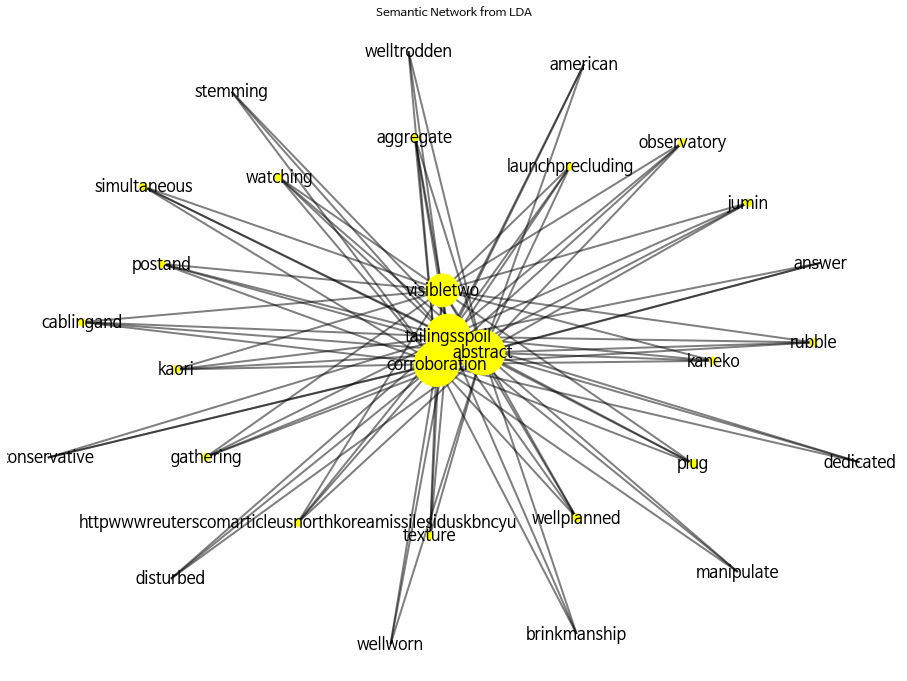

In [ ]:
def get_topic_documents(model):
    """주어진 토픽 모델링 결과에서 토픽 문서를 생성하여 돌려준다."""
    
    print_log_msg("Generating topic word documents.")
    topic_documents = []
    
    for topic_id in range(model.num_topics):
        topic_document = []
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)

        for topic_word, prob in topic_word_probs:
            topic_document.append(topic_word)
            
        topic_documents.append(topic_document)
        
    return topic_documents

def build_word_cooc_mat(model):
    """주어진 토픽 모델링 결과에서 어휘 공기 행렬을 생성하여 돌려준다."""
    
    print_log_msg("Building topic word co-occurrence matrix.")
    word_cooc_mat = defaultdict(Counter)
    topic_documents = get_topic_documents(model)
    
    for topic_document in topic_documents:
        for word1, word2 in combinations(topic_document, 2):
            word_cooc_mat[word1][word2] += 1
            
    return word_cooc_mat

def get_sorted_word_coocs(word_cooc_mat):
    """주어진 어휘 공기 행렬에서 공기 빈도로 역술 정렬된 행렬을 생성하려 돌려준다."""
    
    print_log_msg("Sorting topic word occurrence.")
    word_coocs = []
    
    for word1, word2_counter in word_cooc_mat.items():
        for word2, count in word2_counter.items():
            word_coocs.append((word1, word2, count))
            
    sorted_word_coocs = sorted(word_coocs, key=itemgetter(2), reverse=True)
    
    
    return sorted_word_coocs


def build_word_cooc_network(sorted_word_coocs):
    """토픽 단어 공기 네트워크를 생성하여 돌려준다."""
    
    print_log_msg("Generating topic word co-occurrence network.")
    G = nx.Graph()

    for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
        G.add_edge(word1, word2, weight=count)
        
    return G


def return_log_scaled_lst(input_lst):
    r_lst = map(np.log, input_lst)
    try:
        max_v = max(map(np.log, input_lst))
        min_v = min(map(np.log, input_lst))
        return map(lambda v: (v-min_v)/(max_v-min_v), r_lst) #min-max scaling in log-scale.
    except: 
        print(input_lst)
        
def print_log_msg(msg):
    """로그 메시지를 출력한다."""
    
    print(msg, flush=True)


def plot_weighted_graph(sorted_word_coocs):
    "Plot a weighted graph"
    
    print_log_msg("Generating topic word co-occurrence network.")
    
    plt.figure(figsize=(16, 12))
    plt.axis('off')
    plt.title('Semantic Network from LDA')
    plt.margins(x=0.05, y=0.05)
    
    G = nx.Graph()

    for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
        G.add_edge(word1, word2, weight=count)
        
    pos = nx.spring_layout(G, scale=3.)
        
    #measures = nx.in_degree_centrality(G)
    #measures = nx.betweenness_centrality(G)
    measures = nx.closeness_centrality(G)
    node_weight_lst = return_log_scaled_lst([n_weight for n_weight in measures.values()])
    edge_weight_lst = return_log_scaled_lst([e[2]['weight'] for e in G.edges(data=True)])
    
    
    all_weights = []

    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) # we'll use this when determining edge thickness
 
    unique_weights = list(set(all_weights))
    #print(sum(all_weights)) = 280
    nodes = nx.draw_networkx_nodes(G, pos, node_size=list(map(lambda x: x*2000, node_weight_lst)),
                                   node_color="yellow",
                                   nodelist=list(measures.keys())
                                  )
    #nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    labels = {}
    for node_name in measures.keys():
        labels[str(node_name)] = str(node_name)
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_family=font_name)


    for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        width = weight #sum(all_weights) * 300.0
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, alpha=0.5)
 
    print_log_msg("Drawing topic word network.")
    plt.savefig(save_path+"network_plot.png") 
    plt.show()
    
    return G


word_cooc_mat = build_word_cooc_mat(model)
sorted_word_coocs = get_sorted_word_coocs(word_cooc_mat)
G = plot_weighted_graph(sorted_word_coocs)

### 주어진 단어에 대해서 동시 등장(연어) 횟수가 높은 의미연결망 만들기. 


Top N? : 50

키워드를 입력해주세요 : nuclear


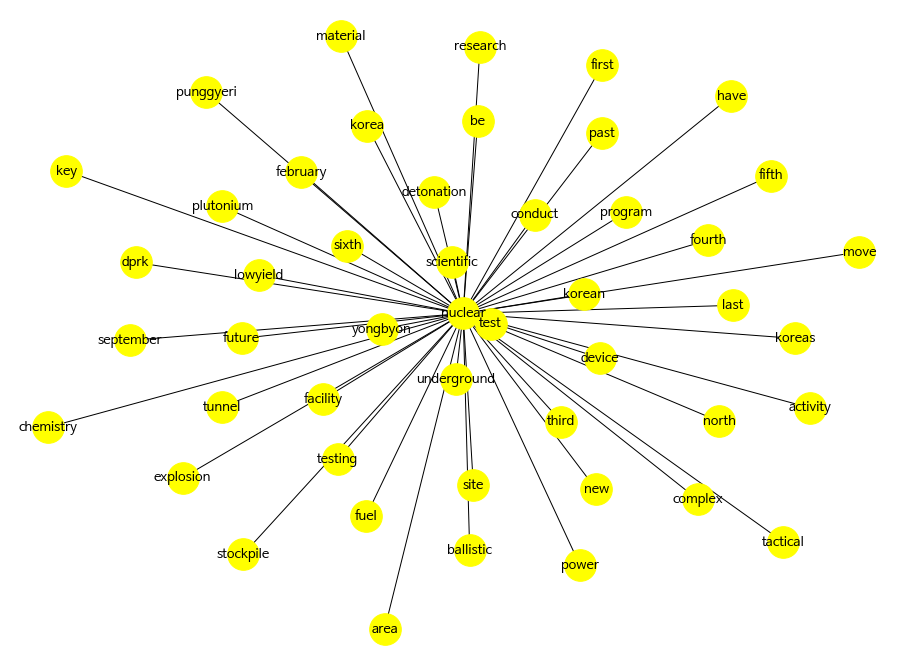

In [ ]:
"""
전체 corpus의 bigram을 구한 뒤, 분석 키워드를 중심으로 Semantic Network를 생성한다.
"""
freq_analysis = False

def bigram_function(documents):
    
    bigram_corpus = []
    
    for doc in documents:
        bigram_corpus += bigrams(doc)

    return bigram_corpus


def frequency_checking(documents, N):

    total_tokens = [token for doc in documents for token in doc]
    print("Total tokens : ", len(total_tokens))
    
    text = nltk.Text(total_tokens, name='freqs')
    print("Unique tokens : ", len(set(text.tokens)))
    pprint(text.vocab().most_common(N))
    

def bigram_frequency_checking(bigrams, N):

    print("\n\nTotal bigrams : ", len(bigrams))

    freq_dict = {}
    
    for bigram in bigrams:
        freq_dict[bigram] = freq_dict.get(bigram, 0) + 1
#         if bigram in freq_dict:
#             freq_dict[bigram] += 1
#         else:
#             freq_dict[bigram] = 1
        
            
    sorted_freq_dict = sorted(freq_dict.items(), key=itemgetter(1), reverse=True)

    print("Unique bigrams : ", len(set(bigrams)))
    
    for k, v in sorted_freq_dict[:N]:
        print(k, v)

        
def build_sorted_keywords(bigrams, keyword, N):

    freq_dict = {}
    
    for bigram in bigrams:
        if keyword in bigram:
            freq_dict[bigram] = freq_dict.get(bigram, 0) + 1
            
    sorted_freq_dict = sorted(freq_dict.items(), key=itemgetter(1), reverse=True)

    if freq_analysis:
        print("\nNumber of bigrams : ", len(sorted_freq_dict))
        
        for k, v in sorted_freq_dict[:N]:
            print(k, v)

    return sorted_freq_dict[:N]   
    
    
def build_word_sim_network(sorted_word_sims, keyword):
    """어휘 유사도 네트워크를 생성하여 돌려준다."""
    
    G = nx.Graph()
    #max_count = 30

    for bigram, count in sorted_word_sims:
        word1, word2 = bigram[0], bigram[1]
        
        if word1 == keyword:
#             if max_count == 0:
#                 break
#             max_count -= 1
            #print(word1, word2, sim)
            G.add_edge(word1, word2, weight=count)
            
        elif word2 == keyword:
#             if max_count == 0:
#                 break
#             max_count -= 1
            #print(word1, word2, sim)
            G.add_edge(word2, word1, weight=count)
            
    T = nx.minimum_spanning_tree(G)

    return T


def draw_network(G):
    """어휘 공기 네트워크를 화면에 표시한다."""
    
    plt.figure(figsize=(16, 12))
    nx.draw_networkx(G,
            pos=nx.spring_layout(G, k=0.8),
            node_size=1000,
            node_color="yellow",
            font_family=font_name,
            with_labels=True,
            font_size=13)

    plt.axis("off")
    plt.savefig(save_path+f"semantic_network({dataname})_collocation.pdf")
    plt.show()
 


"""어휘 유사도 행렬을 구성한 뒤 이를 네트워크로 시각화한다."""

documents = tokenized_set
bigram_corpus = bigram_function(documents)
N = int(input("\nTop N? : "))
if freq_analysis:
    frequency_checking(documents, N)
    bigram_frequency_checking(bigram_corpus, N)

keyword = input("\n키워드를 입력해주세요 : ")
sorted_bigrams = build_sorted_keywords(bigram_corpus, keyword, N)
G = build_word_sim_network(sorted_bigrams, keyword)
draw_network(G)

### 주어진 단어에 대해서 동시 등장(co-occurence)가 높은 의미 연결망 만들기 

Building a Document-Term Matrix.
Building a co-occurrence matrix.

Top N? : 30
키워드를 입력해주세요 : nuclear
Calculating Similarity matrix.
Now Sorting..
Done.


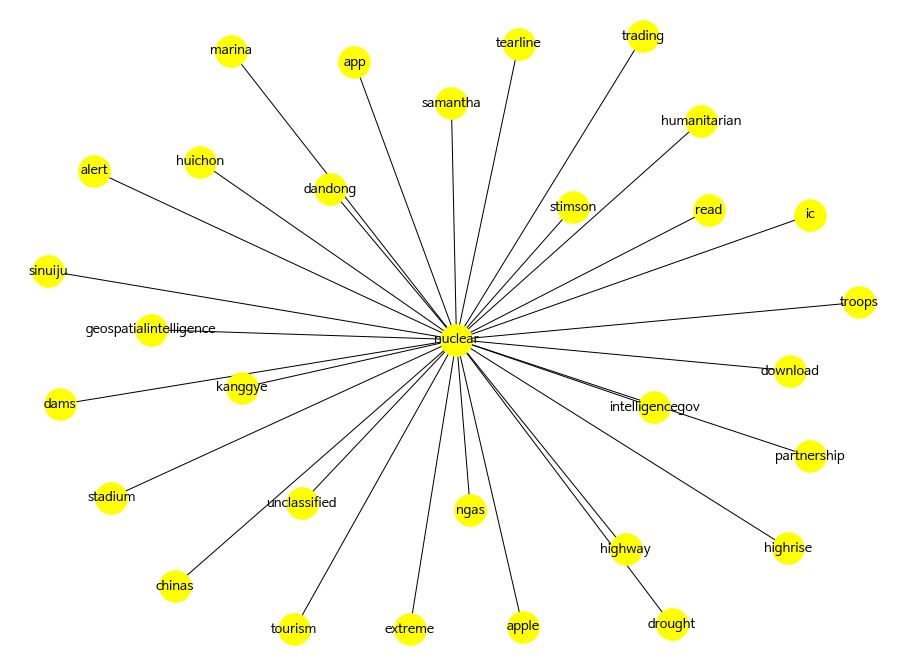

In [ ]:
"""
전체 corpus의 co-occurence를 구한 뒤, 분석 키워드를 중심으로 Semantic Network를 생성한다.
"""

def build_doc_term_mat(documents):
    """주어진 문서 집합으로부터 문서-어휘 행렬을 생성하여 돌려준다."""
    print("Building a Document-Term Matrix.")
    vectorizer = CountVectorizer(min_df=5, tokenizer=str.split, binary=True)
    doc_term_mat = vectorizer.fit_transform(documents)   
    words = vectorizer.get_feature_names()
    
    return doc_term_mat, words
        
    
def build_word_cooc_mat(doc_term_mat):
    """주어진 문서-어휘 행렬부터 어휘 공기 행렬을 생성하여 돌려준다."""
    
    print("Building a co-occurrence matrix.")
    word_cooc_mat = doc_term_mat.T * doc_term_mat
    word_cooc_mat.setdiag(0)
    
    return word_cooc_mat


def get_word_sim_mat(word_cooc_mat):
    """주어진 어휘 공기 행렬에 대하여 어휘 유사도 행렬을 구하여 돌려준다."""
    
    print("Calculating Similarity matrix.")
    word_sim_mat = pdist(word_cooc_mat.toarray(), metric="correlation")
    word_sim_mat = squareform(word_sim_mat)
    
    return word_sim_mat


def get_sorted_word_sims(word_sim_mat, words):
    """주어진 어휘 유사도 행렬을 정렬하여 출력한다."""
    
    print("Now Sorting..")
    word_sims = []
    
    for i, j in combinations(range(len(words)), 2):
        sim = word_sim_mat[i, j]
        
        if sim == 0:
            continue
            
        word_sims.append((words[i], words[j], sim))
        
    sorted_word_sims = sorted(word_sims, key=itemgetter(2), reverse=True)
#     for k, v in sorted_word_sims[:N]:
#         print(k, v)

    return sorted_word_sims

def build_word_sim_network(sorted_word_sims, keyword, N):
    """어휘 유사도 네트워크를 생성하여 돌려준다."""
    
    G = nx.Graph()
    
    max_count = N
    for word1, word2, sim in sorted_word_sims:
        
        if word1 == keyword:
            if max_count == 0:
                break
            max_count -= 1
#            print(word1, word2, sim)
            G.add_edge(word1, word2, weight=sim)
            
        elif word2 == keyword:
            if max_count == 0:
                break
            max_count -= 1
#            print(word1, word2, sim)
            G.add_edge(word2, word1, weight=sim)
        
    T = nx.minimum_spanning_tree(G)

    return T


def draw_network(G):
    """어휘 공기 네트워크를 화면에 표시한다."""
    
    print("Done.")
    plt.figure(figsize=(16, 12))
    nx.draw_networkx(G,
            pos=nx.spring_layout(G, k=0.8),
            node_size=1000,
            node_color="yellow",
            font_family=font_name,
            with_labels=True,
            font_size=13)

    plt.axis("off")
    plt.savefig(save_path+"co-occurence_semantic_network.pdf")
    plt.show()
    
    

documents = [" ".join(tokens) for tokens in tokenized_set]
doc_term_mat, words  = build_doc_term_mat(documents)
word_cooc_mat = build_word_cooc_mat(doc_term_mat)
N = int(input("\nTop N? : "))
keyword = input("키워드를 입력해주세요 : ")
word_sim_mat = get_word_sim_mat(word_cooc_mat)
sorted_word_sims = get_sorted_word_sims(word_sim_mat, words)
G = build_word_sim_network(sorted_word_sims, keyword, N)
draw_network(G)

## Community Detection

Drawing Community Detected network.


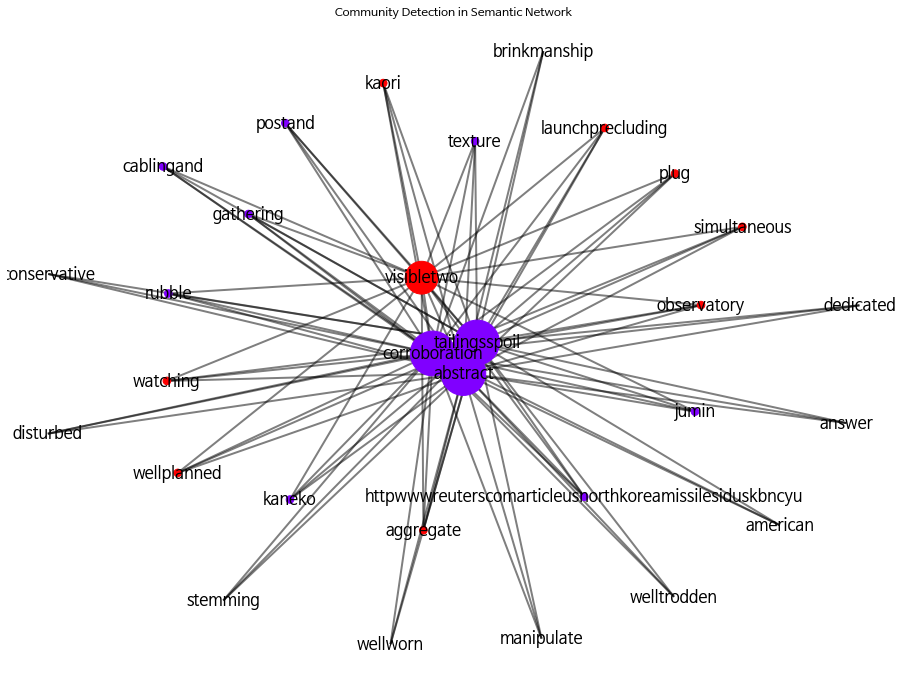

In [ ]:
import community

print_log_msg("Drawing Community Detected network.")
plt.figure(figsize=(16, 12))
plt.axis('off')
plt.title('Community Detection in Semantic Network')
plt.margins(x=0.05, y=0.05)

G = nx.Graph()

for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
    G.add_edge(word1, word2, weight=count)

pos = nx.spring_layout(G, scale=3.)

#measures = nx.in_degree_centrality(G)
#measures = nx.betweenness_centrality(G)
measures = nx.closeness_centrality(G)
node_weight_lst = return_log_scaled_lst([n_weight for n_weight in measures.values()])
edge_weight_lst = return_log_scaled_lst([e[2]['weight'] for e in G.edges(data=True)])

parts = community.best_partition(G)
groups = [parts.get(node) for node in G.nodes()]

all_weights = []
for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight']) #we'll use this when determining edge thickness

unique_weights = list(set(all_weights))
#print(sum(all_weights)) = 280
nodes = nx.draw_networkx_nodes(G, pos, node_size=list(map(lambda x: x*2000, node_weight_lst)),
                               cmap=plt.cm.rainbow,
                               node_color=groups,
                               nodelist=list(measures.keys())
                              )
labels = {}
for node_name in measures.keys():
    labels[str(node_name)] = str(node_name)
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_family=font_name)


for weight in unique_weights:
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight #sum(all_weights) * 300.0
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, alpha=0.5)

plt.savefig(save_path+"community_detection_plot.png") 
plt.show()

## Document Clustering

- 비슷한 문서들끼리 모아주는 기법.

- 비슷하지 않은 문서들끼리는 모아주지 않는 기법.

In [ ]:
from sklearn.cluster import KMeans

vec = CountVectorizer(max_features=3000) # 빈도 기준 상위 3000개의 단어를 사용.
raw_docs = [" ".join(doc) for doc in tokenized_set] 
X = vec.fit_transform(raw_docs)

# 위에서 선정한 토픽 개수만큼의 그룹으로 문서들을 묶어줍니다.
kmeans = KMeans(n_clusters=NUM_TOPICS).fit(X)

print(kmeans.labels_)

[2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2
 0 2 2 2 2 2 2 2 0 2 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 0 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 0 2 2 2 1 0 2 2 2 1 2 2 1 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 0 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0 1 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 0 2 2 1 2 2 2 2 2 1 2 2
 2 1 2 1 1 2 1 2 1 1 2 2 2 1 2 2 2 2 0 2 0 2 2 2 1 0 2 1 1 2 2 2 2 1 1 2 2
 2 2 0 0 2 1 2 1 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2]


### K-means 결과 시각화

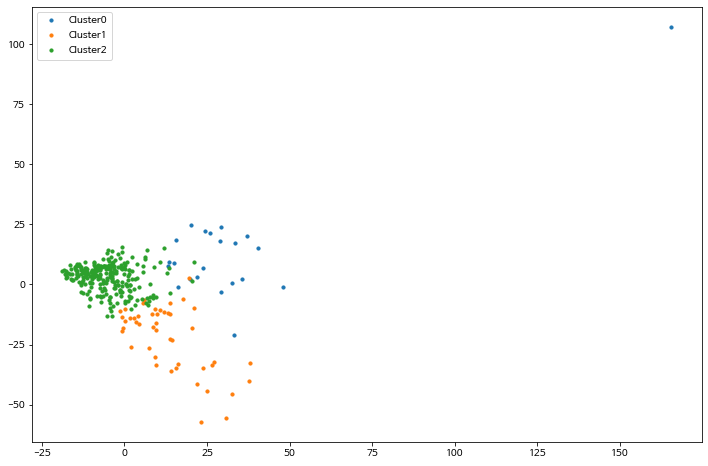

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False
%matplotlib inline


plt.figure(figsize=(12, 8))
pca = PCA(n_components=2)
pca_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

reduced_data = pca.fit_transform(pca_df)
reduced_df = pd.DataFrame(data=reduced_data,
                         columns=["Principal Components 1", "Principal Components 2"])

for topic in range(NUM_TOPICS):    
    plt.scatter(reduced_df.iloc[kmeans.labels_ == topic, 0],
               reduced_df.iloc[kmeans.labels_ == topic, 1], s=10, cmap=cm.rainbow, label="Cluster{}".format(topic))
# plt.scatter(reduced_df.iloc[kmeans.labels_ == 1, 0],
#            reduced_df.iloc[kmeans.labels_ == 1, 1], s=10, c="blue", label="Cluster2")
# plt.scatter(reduced_df.iloc[kmeans.labels_ == 2, 0],
#            reduced_df.iloc[kmeans.labels_ == 2, 1], s=10, c="green", label="Cluster3")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

np_X = np.array(X.todense())
score = silhouette_score(np_X, kmeans.labels_)
print(score)

0.22166648140050904


## Word Embedding 

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(tokenized_set, min_count=5, size=50, sg=1, iter=100, workers=4, ns_exponent=0.75, window=7)
if os.path.exists(save_path+"w2v_model_({})".format(dataname)):
    w2v_model = Word2Vec.load("w2v_model_({})".format(dataname))
else:
    w2v_model.save(save_path+'w2v_model')

In [ ]:
if language == "kor":
    w2v_model.wv.most_similar('핵실험')
elif language == "eng":
    w2v_model.wv.most_similar('nuclear')

### word embedding space 시각화

In [ ]:
word_vectors = w2v_model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

In [ ]:
embedding_words = pca.fit_transform(word_vectors_list)
xs = embedding_words[:, 0]
ys = embedding_words[:, 1]

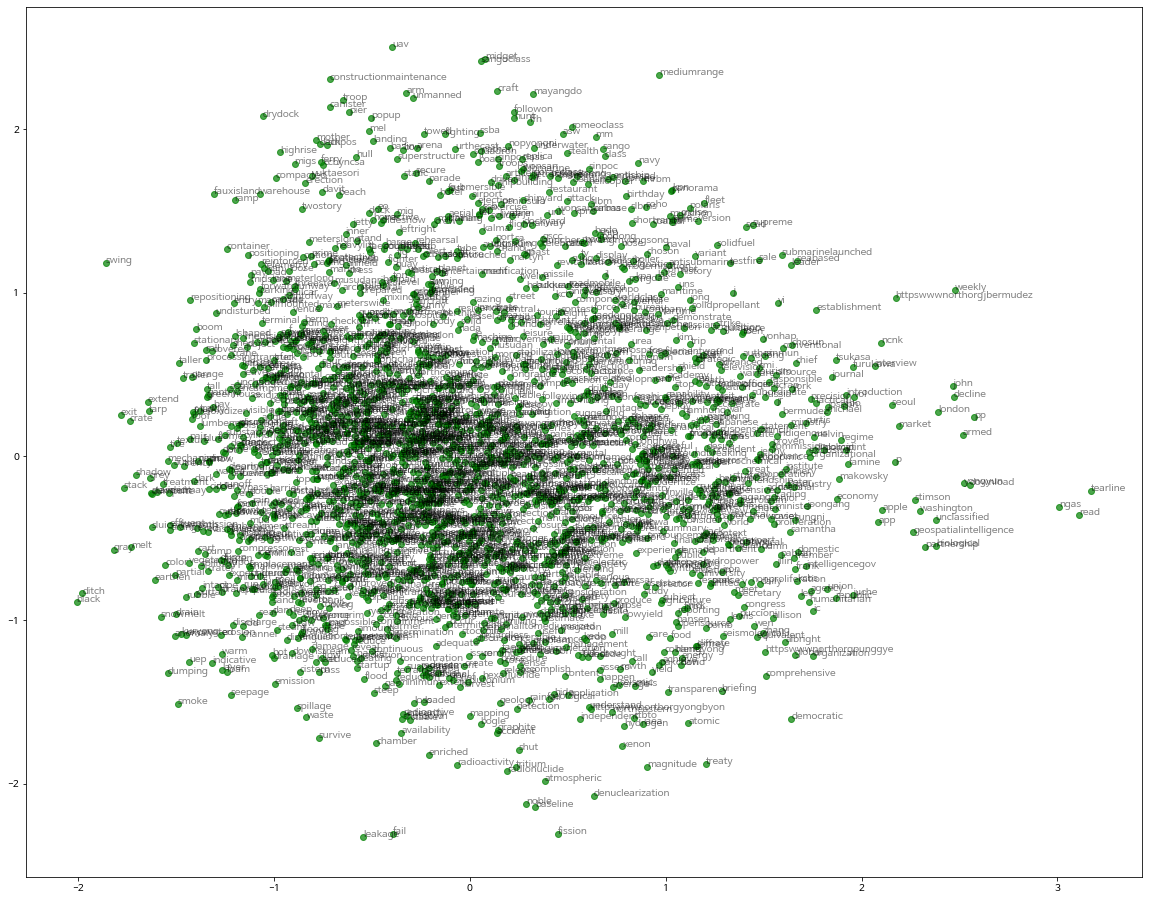

In [ ]:
plt.figure(figsize=(20, 16))
plt.scatter(xs, ys, marker='o', alpha=0.7, color="green")
for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]), alpha=0.5)

plt.savefig(save_path+"word_embedding_plot_{}.png".format(dataname))
plt.show()